In [1]:
import numpy as np 
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
from scipy.optimize import curve_fit
from scipy.interpolate import *
import os



In [2]:
### This loads in every .txt file in the specified path 
### It is slightly hardcoded for the specific data format produced by SPRAria, but should be easily
### changeable to other formats
def loader(adir):
    i = 0
    names = os.listdir(adir)
    d = {}
    for i in range(0,np.size(names)):
        #print(i)
        if names[i][-4:] == ".txt":
            try:
                d[str(names[i][:-4])] = np.loadtxt(adir+str(names[i]),skiprows=1,usecols=(0,3))
            except IndexError:
                print("Data file "+str(names[i])+" did not contain SPR data")
    #print(d)
    return(d)

In [3]:
### This produces two plots:
### The first is the SPR curve for the files "conc0", "conc1" up to "conc(num)" which you specify /
### when calling the function, and then plots "rinse" at the end.
### "conc" and "rinse" are the default names but can be passed as arguments to the function
### The second plot is the same as the first but with the addition of splines for each concentration.
### The equilibrium pixel valu for each concentration is then taken as the end value of each spline
### The function then returns these pixel values for each concentraion, along with an error which is /
### the width of the grey regions around each spline
### The second plot is to visually confirm that the splines are reasonable. If not, you can change the /
### value of the smoothing parameter from it's default of 10

def visualfitter(d,num,filename="conc",rinsename="rinse",smoothing=10):
    plt.figure(figsize=(14,10))
    for i in range(0,num):
        #print(d[filename+`i+1`][-1,0])
        #print(d[filename+`i`][-1,0])
        for j in range(0,np.size(d[filename+`i+1`][:,0])):
            #print(j)
            d[filename+`i+1`][j][0] =d[filename+`i+1`][j][0] + d[filename+`i`][-1][0]
        #print(d[filename+`i+1`][-1][0])
    for j in range(0,np.size(d[rinsename][:,0])):
        d[rinsename][j][0] =d[rinsename][j][0] + d[filename+str(num)][-1][0]
    
    d2 = {}
    errors = np.zeros(num+1)
    pixels = np.zeros(num+1)
    for i in range(0,num+1):
        #print(i)
        temparray = np.zeros(np.shape(d[filename+`i`]))
        errors[i] = np.max(d[filename+`i`][-50:,1]) - np.min(d[filename+`i`][-50:,1])
        f = UnivariateSpline(d[filename+`i`][:,0]/60, d[filename+`i`][:,1], s=smoothing)
        temparray[:,0] = d[filename+`i`][:,0]/60
        temparray[:,1] = f(d[filename+`i`][:,0]/60)
        d2[filename+`i`] = temparray
        pixels[i] = d2[filename+`i`][-1,1] - d2[filename+"0"][-1,1]
        
        
    cmap = plt.get_cmap('jet')
    colors = [cmap(i) for i in np.linspace(0, 1, num+2)]

    for i in range(0,num+1):
        plt.plot(d[filename+`i`][:,0]/60,d[filename+`i`][:,1],label=filename+`i`,color=colors[i])
    plt.plot(d[rinsename][:,0]/60,d[rinsename][:,1],label=rinsename,color=colors[num+1])

    #plt.ylim([772,784])
    #plt.xlim([0,150])
    plt.title("BTK PH Domain in 75:20:05 DOPC:DOPS:PIP3")
    plt.ylabel("SPR Signal (pixels)")
    plt.xlabel("Time (minutes)")
    plt.legend(prop={'size':10})
    plt.show()
    plt.figure(figsize=(14,10))
    cmap = plt.get_cmap('jet')
    colors = [cmap(i) for i in np.linspace(0, 1, num+2)]

    for i in range(0,num+1):
        plt.plot(d[filename+`i`][:,0]/60,d[filename+`i`][:,1],label=filename+`i`,color=colors[i])
        plt.plot(d2[filename+`i`][:,0],d2[filename+`i`][:,1],color='black',linewidth=3)
        plt.fill_between(d2[filename+`i`][:,0],d2[filename+`i`][:,1]-errors[i]/2,d2[filename+`i`][:,1]+errors[i]/2,color='gray',edgecolor='black',alpha=0.4)
        plt.plot(d2[filename+`i`][:,0],d2[filename+`i`][:,1],color='white',linewidth=1)
        #plt.plot(d2[filename+`i`](d[filename+`i`][:,0]/60),d2[filename+`i`](d[filename+`i`][:,1]),label=filename+`i`+" FIT",color='black')
    #plt.plot(d[rinsename][:,0]/60,d[rinsename][:,1],label=rinsename,color=colors[num+1])

    #plt.ylim([772,784])
    #plt.xlim([0,150])
    plt.title("BTK PH Domain in 75:20:05 DOPC:DOPS:PIP3")
    plt.ylabel("SPR Signal (pixels)")
    plt.xlabel("Time (minutes)")
    plt.legend(prop={'size':10})
    plt.show()
    return(pixels,errors)

In [4]:
def Langmuir(concs,bmax,kd):
    return (concs*bmax)/(concs+kd)

In [11]:
def FitToLangmuir(concs,pixels,errors):
    popt, popv = curve_fit(Langmuir,concs,pixels,sigma=errors,bounds=(0,[1000,1000]))
    plt.figure(figsize=(10,8))
    plt.errorbar(concs,pixels,yerr=errors/2,fmt='o')
    plt.plot(concs,Langmuir(concs,*popt))
    plt.title("Langmuir Binding Curve")
    plt.xscale('log')
    plt.ylabel("R_eq")
    plt.xlabel("Concentration (um)")
    plt.show()
    
    print("[bmax, k_d] = ",popt)
    print("[bmax_err, k_d_err] = ",np.sqrt(popv))   

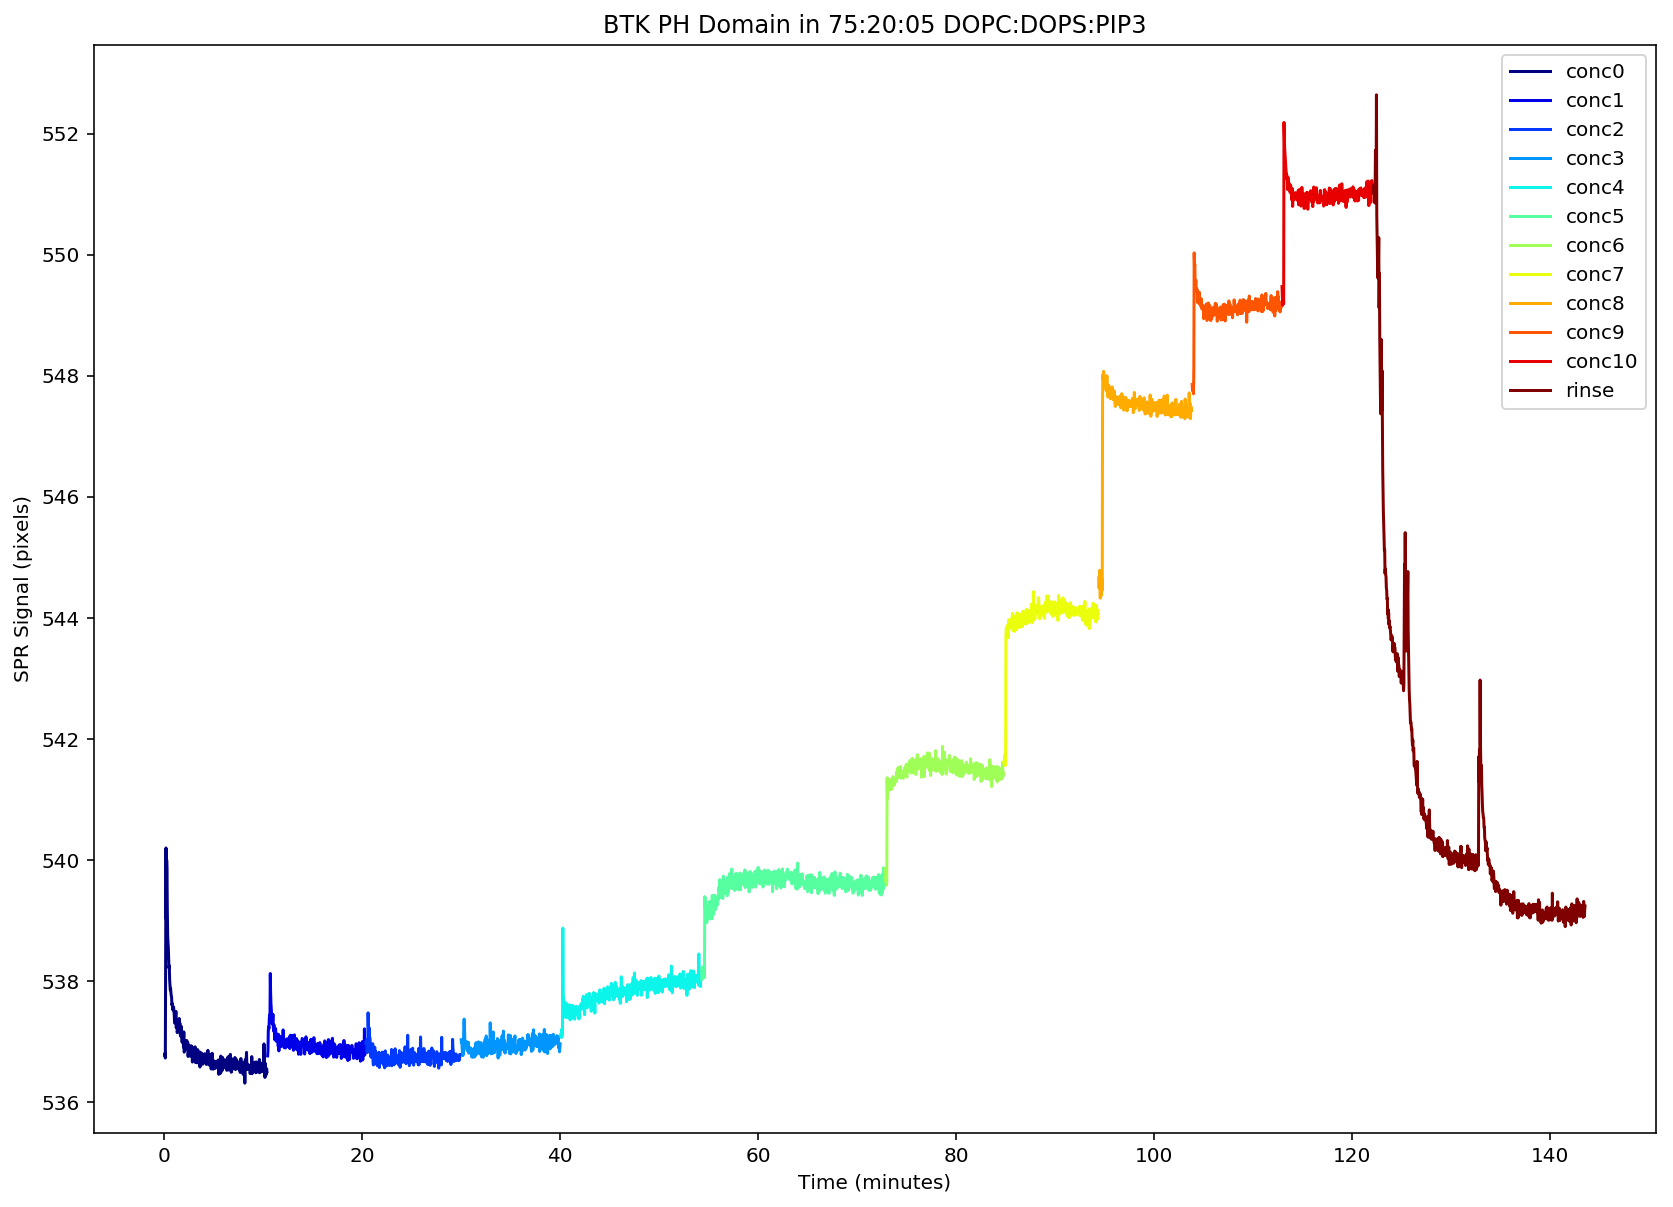

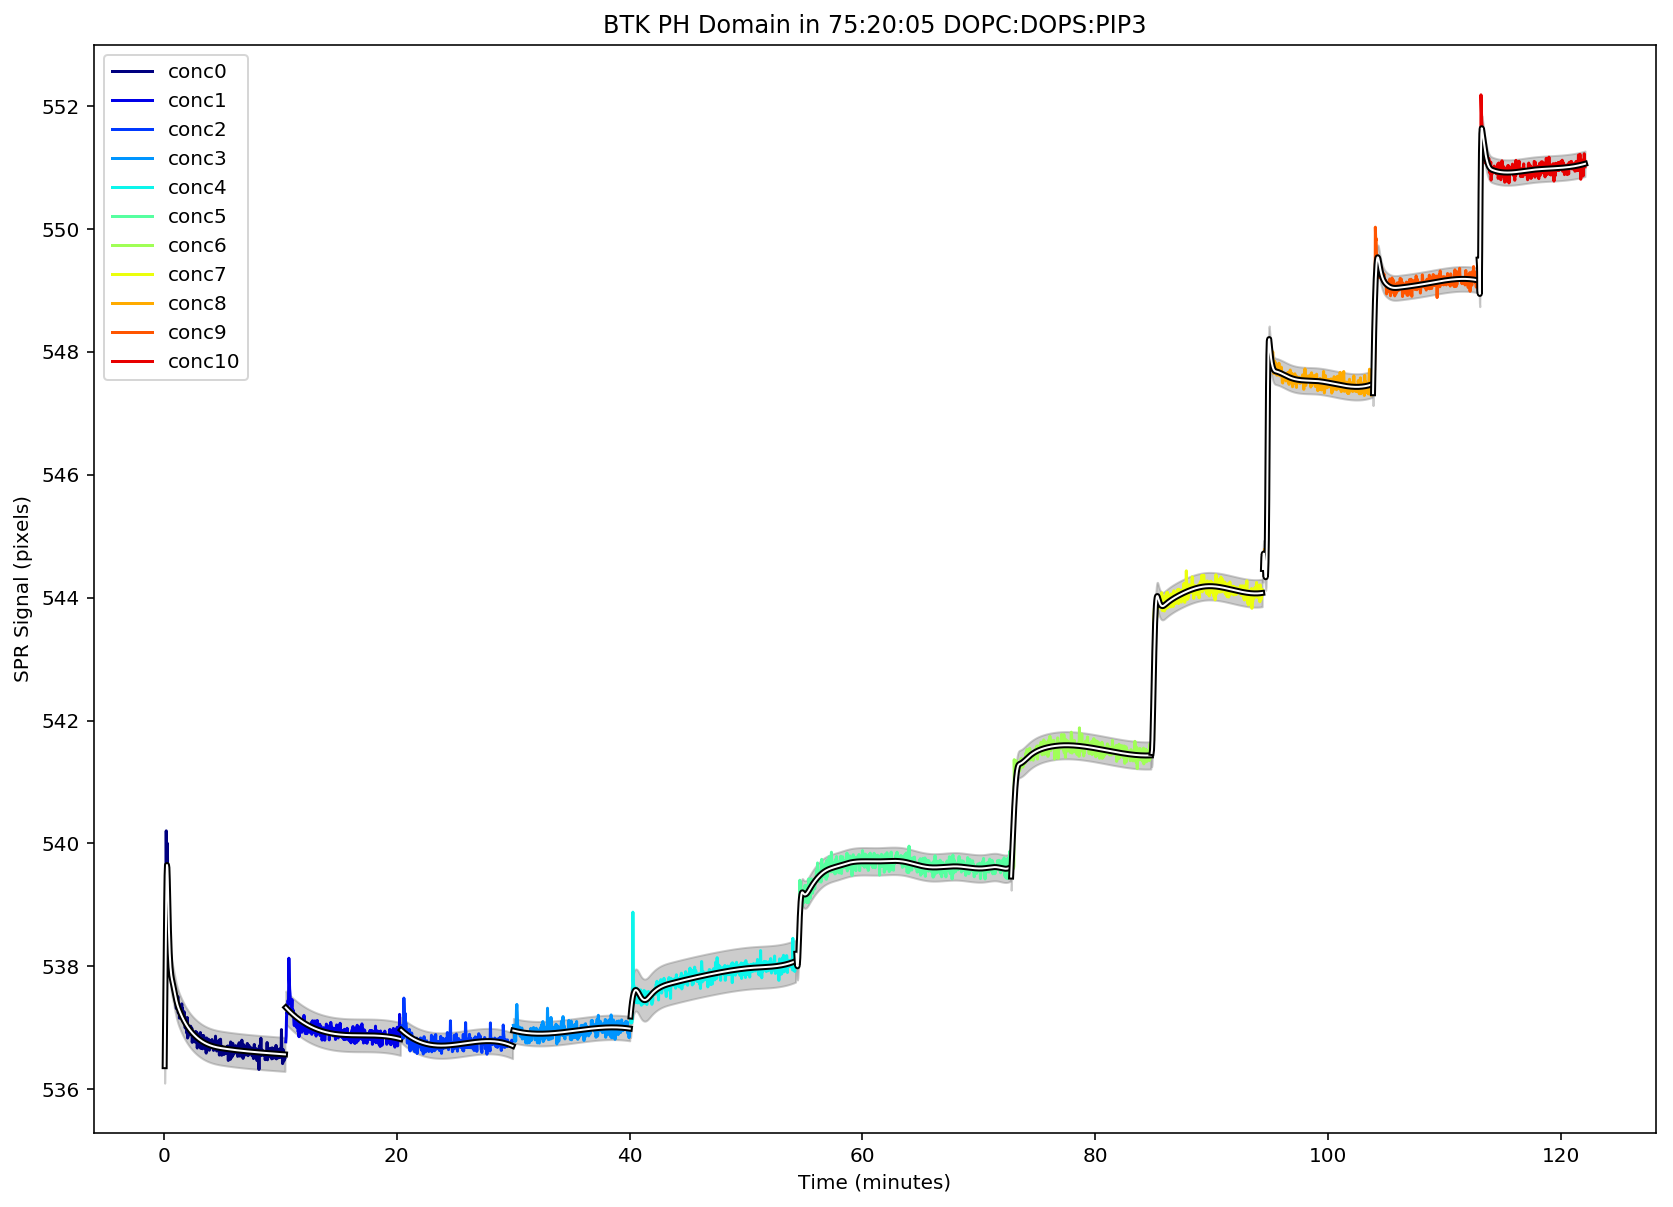

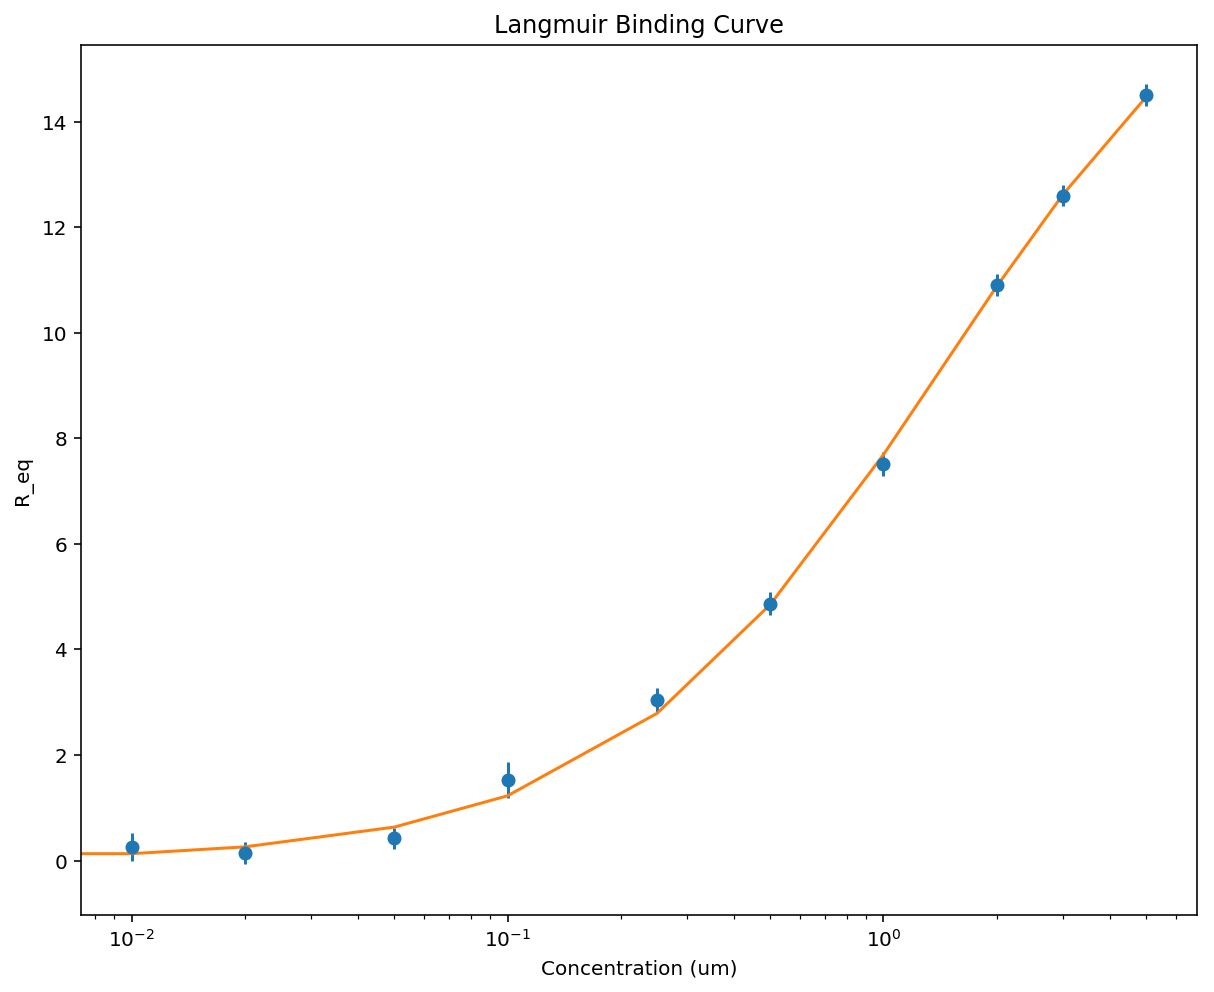

('[bmax, k_d] = ', array([ 18.56192039,   1.41297152]))
('[bmax_err, k_d_err] = ', array([[ 0.29262777,  0.12621924],
       [ 0.12621924,  0.05903289]]))


In [12]:

###The various concentrations have to be manually added below in micromolar
concs = np.array([0,0.01,0.02,0.05,0.1,0.25,0.5,1,2,3,5])


d = loader("../../../Downloads/7-27-15/")

(pixels,errors) = visualfitter(d,10,smoothing=5)

FitToLangmuir(concs,pixels,errors)